# NLP Pipeline for Toxicity Detection in Eredivisie Twitter Communities

This notebook implements the Natural Language Processing (NLP) component of a broader tool designed to detect and analyze toxic behavior in Dutch football-related Twitter conversations. It processes and classifies tweets scraped during Eredivisie matches, preparing the dataset for social network analysis.

The goal of this notebook is to apply both pre-trained and fine-tuned language models to:
- Filter tweets by language (Dutch, English, other)
- Assign toxicity scores and labels
- Merge results into a unified dataset ready for network-level analysis

### Key outputs
- Language-detected tweet data
- Toxicity labels (Dutch: fine-tuned classifiers; English: pretrained models)
- Cleaned and merged DataFrame: `final_sna_dataframe.csv`

### Workflow overview

| Step | Description |
|------|-------------|
| 1–9  | Exploratory data analysis and text statistics |
| 10–15 | Language detection and filtering |
| 16–20 | Manual labeling export and baseline model predictions |
| 21–23 | Fine-tuning Dutch classifiers on labeled data |
| 24–26 | Final inference and cleanup for Dutch tweets |
| 27–29 | Pretrained English model classification |
| 30–33 | Dataset merging, labeling, and export for SNA |

This notebook is part of a modular pipeline and is designed to be readable, reproducible, and extensible.


## Tooling & Library Choices

This notebook was developed using **Python** due to its strong ecosystem for natural language processing and machine learning. All major components — data processing, model training, inference, and evaluation — are built using widely adopted open-source packages:

- **HuggingFace Transformers**: provides easy access to hundreds of pre-trained language models (BERT, RoBERTa, etc.), including both Dutch and English toxicity classifiers.
- **PyTorch**: used for fine-tuning models with full control over training loops, GPU acceleration, and customization. PyTorch is also the backend for many HuggingFace models.
- **scikit-learn**: used for computing evaluation metrics such as precision, recall, and F1-score, as well as tools for cross-validation and data splitting.
- **langdetect**: used for lightweight, language-agnostic detection of tweet language, important for multilingual datasets.
- **pandas, matplotlib, seaborn**: for data manipulation and visualization throughout the exploratory and evaluation stages.

These libraries were chosen not only for their functionality, but also for their:
- **Community support and documentation**
- **Compatibility with research workflows**
- **Ease of integration into modular pipelines**

Alternatives (e.g., TensorFlow, spaCy, FastText) were considered but not selected due to either limited Dutch model availability or lower alignment with the fine-tuning and inference goals of this project.


In [ ]:
# ==============================================
# Step 1: Import libraries
# ==============================================

import os
import re
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import f1_score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch


## Load merged tweet dataset

In this step, we load the cleaned and merged dataset containing all timeline tweets and replies (Layer 0, 1, and 2) for further analysis. The dataset was generated in the previous notebook `merge_scraped_tweets.ipynb`, and includes the following columns:

- `text`: the raw tweet content
- `match_id`: a unique identifier for the match event
- `author`: username of the account that posted the tweet
- `team_handle`: the official Eredivisie club associated with the tweet
- `timestamp`: when the tweet was posted
- `thread_depth`: indicator of whether the tweet is an original (0), reply (1), or reply-to-reply (2)

This unified dataset serves as the input for both the exploratory analysis and the toxicity classification tasks later in the notebook.

In [ ]:
# ==============================================
# Step 2: Load merged tweet dataset and match metadata
# ==============================================

# Load the combined dataset of Twitter replies
df = pd.read_csv("C:\Master\Master project\merged_threads_fixed.csv", encoding="utf-8-sig")

# Loading the match metadata
match_metadata = pd.read_csv("C:/Master/Master project/toxic_match_metadata_cleanedV2.csv")

# Show the dataframe
df

,match_id,team_handle,thread_depth,thread_id,author,text,timestamp,tweet_url,parent_author,parent_url,comments,source_file,original_parent_author
0,M001,NACnl,2,https://nitter.net/076Yago/status/182198673460...,@Myrthe_26,🤣🤣🤣,2024-08-09 19:12:00+00:00,https://nitter.net/NACnl/status/18219864530414...,@076Yago,https://nitter.net/076Yago/status/182198673460...,0,second_level_replies_M001_NACnl.csv,@076Yago
1,M001,NACnl,2,https://nitter.net/420jasper_/status/182197233...,@EXFLRussell,bal via het bovenbeen op de arm is geen hands,2024-08-09 20:14:00+00:00,https://nitter.net/NACnl/status/18219720329193...,@420jasper_,https://nitter.net/420jasper_/status/182197233...,0,second_level_replies_M001_NACnl.csv,@420jasper_
2,M001,NACnl,2,https://nitter.net/BigBalard/status/1821955757...,@Vigaltmedia,Hij kan zich melden bij de balie om te betalen.,2024-08-09 19:59:00+00:00,https://nitter.net/NACnl/status/18219546043195...,@BigBalard,https://nitter.net/BigBalard/status/1821955757...,0,second_level_replies_M001_NACnl.csv,@BigBalard
3,M001,NACnl,2,https://nitter.net/Cetfy/status/18219782209396...,@GerriedeB,"Jeetje, wat een sneuneus ben jij zeg.",2024-08-09 18:50:00+00:00,https://nitter.net/NACnl/status/18219781499887...,@Cetfy,https://nitter.net/Cetfy/status/18219782209396...,0,second_level_replies_M001_NACnl.csv,@Cetfy
4,M001,NACnl,2,https://nitter.net/MilanVelde9865/status/18219...,@AdriaanVanden14,Dat deden jullie daarvoor ook al,2024-08-09 21:02:00+00:00,https://nitter.net/NACnl/status/18219986011550...,@MilanVelde9865,https://nitter.net/MilanVelde9865/status/18219...,1,second_level_replies_M001_NACnl.csv,@MilanVelde9865
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21623,M079,Feyenoord,2,https://nitter.net/louisaadrianaV1/status/1910...,@louisaadrianaV1,"Ik ben trainer , en ik kreeg er 50.000 erbij \...",2025-04-11 16:00:00+00:00,https://nitter.net/Feyenoord/status/1910704769...,@louisaadrianaV1,https://nitter.net/louisaadrianaV1/status/1910...,1,second_level_replies_M079_Feyenoord.csv,@louisaadrianaV1
21624,M079,Feyenoord,2,https://nitter.net/louisaadrianaV1/status/1910...,@louisaadrianaV1,-Aanvulling was ik dus daar boos over -,2025-04-11 16:02:00+00:00,https://nitter.net/Feyenoord/status/1910704769...,@louisaadrianaV1,https://nitter.net/louisaadrianaV1/status/1910...,1,second_level_replies_M079_Feyenoord.csv,@louisaadrianaV1
21625,M079,Feyenoord,2,https://nitter.net/luukadona/status/1911314552...,@FeyenoordMening,"Leo zou zeggen: lieve jongen, kom jij uit een ei?",2025-04-13 07:14:00+00:00,https://nitter.net/Feyenoord/status/1911067593...,@luukadona,https://nitter.net/luukadona/status/1911314552...,1,second_level_replies_M079_Feyenoord.csv,@luukadona
21626,M079,Feyenoord,2,https://nitter.net/luukadona/status/1911314552...,@luukadona,"Leo zou zeggen: lieve jongen, dat heb ik in mi...",2025-04-13 11:15:00+00:00,https://nitter.net/Feyenoord/status/1911067593...,@luukadona,https://nitter.net/luukadona/status/1911314552...,0,second_level_replies_M079_Feyenoord.csv,@luukadona


## Explore basic descriptive statistics

This step provides an initial overview of the dataset through several descriptive statistics:

- General dataset properties are summarized using `.describe()` to assess distributions and identify any missing values.
- Tweet content is evaluated by calculating the number of characters (`text_length`) and words (`word_count`) per message.
- Reply volume per match (`match_id`) is analyzed to understand how discussion intensity varies across football events.

These statistics offer valuable context for interpreting the results of later NLP and classification stages.


In [ ]:
# ==============================================
# Step 3: Basic descriptive statistics
# ==============================================

# Basic Descriptive Statistics
print("Basic Descriptive Statistics:\n")
print(df.describe(include='all'))

# Descriptive statistics for text length (characters and words)
df['text_length'] = df['text'].astype(str).apply(len)
df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))

print("\nText Length (Characters) - Statistics:")
print(df['text_length'].describe())

print("\nWord Count - Statistics:")
print(df['word_count'].describe())

# Descriptive statistics for replies per match
replies_per_match = df['match_id'].value_counts()
print("\nReplies per Match - Statistics:")
print(replies_per_match.describe())

Basic Descriptive Statistics:

       match_id team_handle  thread_depth  \
count     21628       21628  21628.000000   
unique       79          18           NaN   
top        M058     AFCAjax           NaN   
freq       1648        5887           NaN   
mean        NaN         NaN      0.923618   
std         NaN         NaN      0.611076   
min         NaN         NaN      0.000000   
25%         NaN         NaN      1.000000   
50%         NaN         NaN      1.000000   
75%         NaN         NaN      1.000000   
max         NaN         NaN      2.000000   

                                                thread_id   author  \
count                                               21628    21628   
unique                                               9001     7316   
top     https://nitter.net/Feyenoord/status/1885722182...  AFCAjax   
freq                                                   40      612   
mean                                                  NaN      NaN   
std     

## Visualize reply distribution across clubs

To understand how fan engagement varies between Eredivisie teams, this step visualizes the number of replies received per club. The `team_handle` field is used to group and count replies directed at each club account, regardless of whether the original tweet was posted by the club or by users replying to it.

This bar chart reveals which clubs receive the most attention on Twitter and may indicate where toxic behavior is most likely to emerge in subsequent analysis.

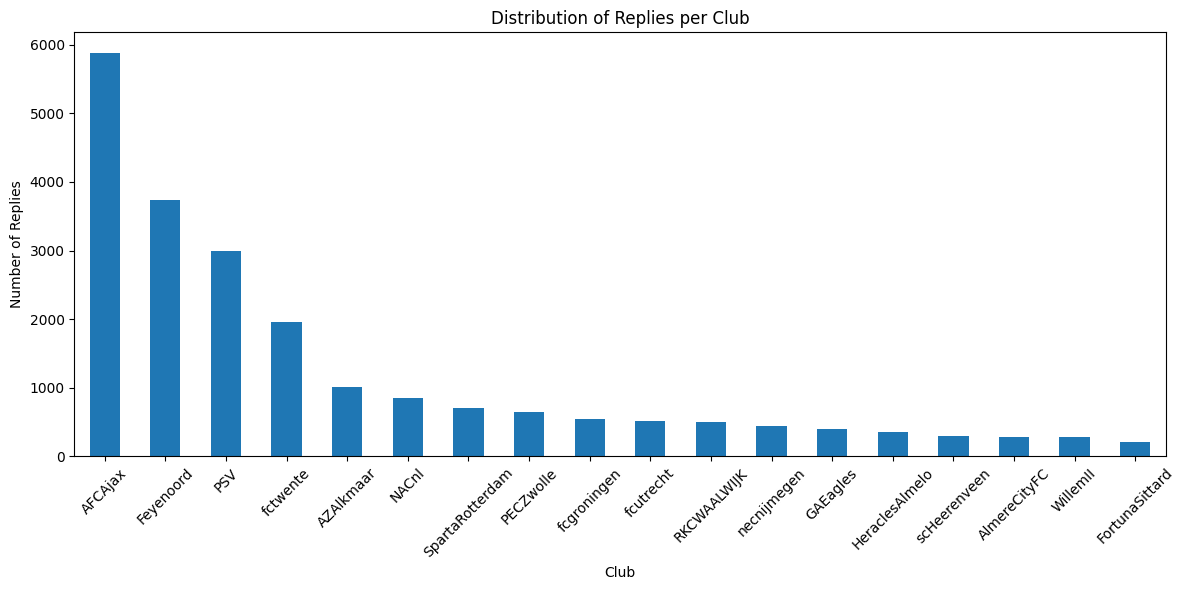

In [ ]:
# ==============================================
# Step 4: Distribution of replies per club
# ==============================================

plt.figure(figsize=(12, 6))
df['team_handle'].value_counts().plot(kind='bar')
plt.title("Distribution of Replies per Club")
plt.xlabel("Club")
plt.ylabel("Number of Replies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Visualize tweets posted by official club accounts

This step isolates and analyzes tweets posted directly by Eredivisie club accounts. Tweets are filtered where `thread_depth == 0`, indicating original (non-reply) posts.

The visualization highlights how frequently each club account publishes content during the selected time window. Understanding club activity levels is important for contextualizing user replies and toxicity patterns in later stages of the analysis.


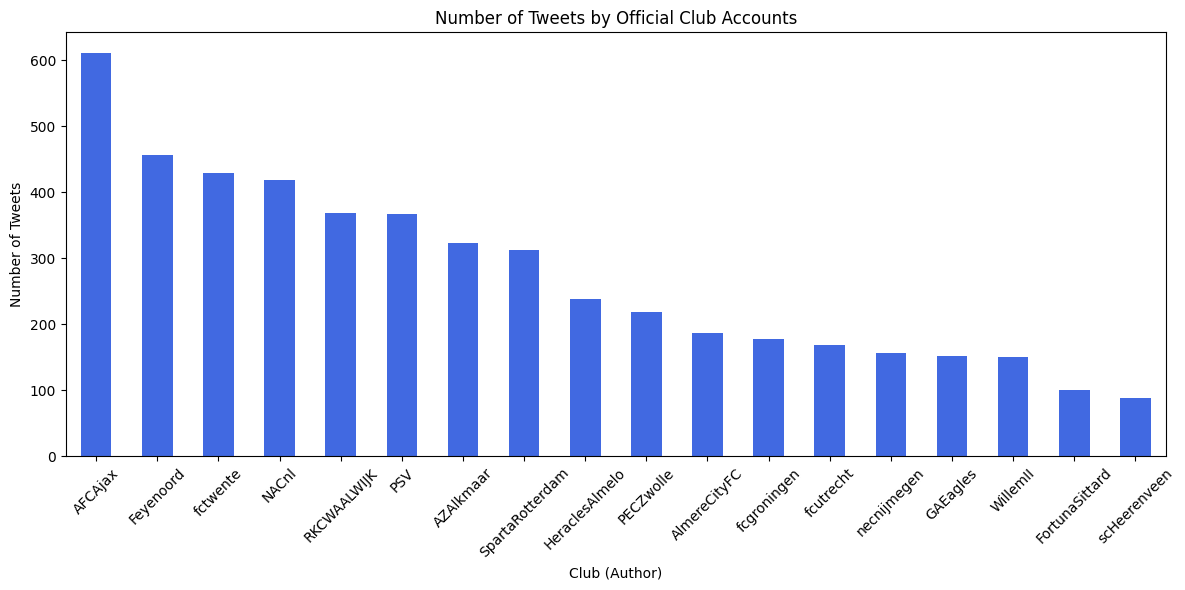

In [ ]:
# ==============================================
# Step 5: Tweets by official club accounts
# ==============================================

# Filtering for official club tweets (thread depth = 0)
club_tweets = df[df['thread_depth'] == 0]

# Counting the number of tweets per club
plt.figure(figsize=(12, 6))
club_tweets['author'].value_counts().plot(kind='bar', color='royalblue')
plt.title("Number of Tweets by Official Club Accounts")
plt.xlabel("Club (Author)")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Identify the most active matches by reply volume

To explore which matches generated the most engagement, this step visualizes the top 20 matches based on the number of replies. Each tweet’s `match_id` is linked with metadata from the match schedule, allowing for descriptive match labels that include the home team, away team, and date.

By combining tweet activity with match context, this chart reveals which football events triggered the highest levels of conversation on Twitter. These matches may also represent key points of interest for later toxicity analysis.

This view reveals which specific fixtures drove the most engagement. Notably, high-profile rivalries like Ajax vs Feyenoord and PSV vs Ajax dominate the list, aligning with expectations that emotionally charged or controversial games generate more online discussion.

C:\Users\timzi\AppData\Local\Temp\ipykernel_60216\3190371914.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=match_labels, x=match_counts.values, palette="viridis")


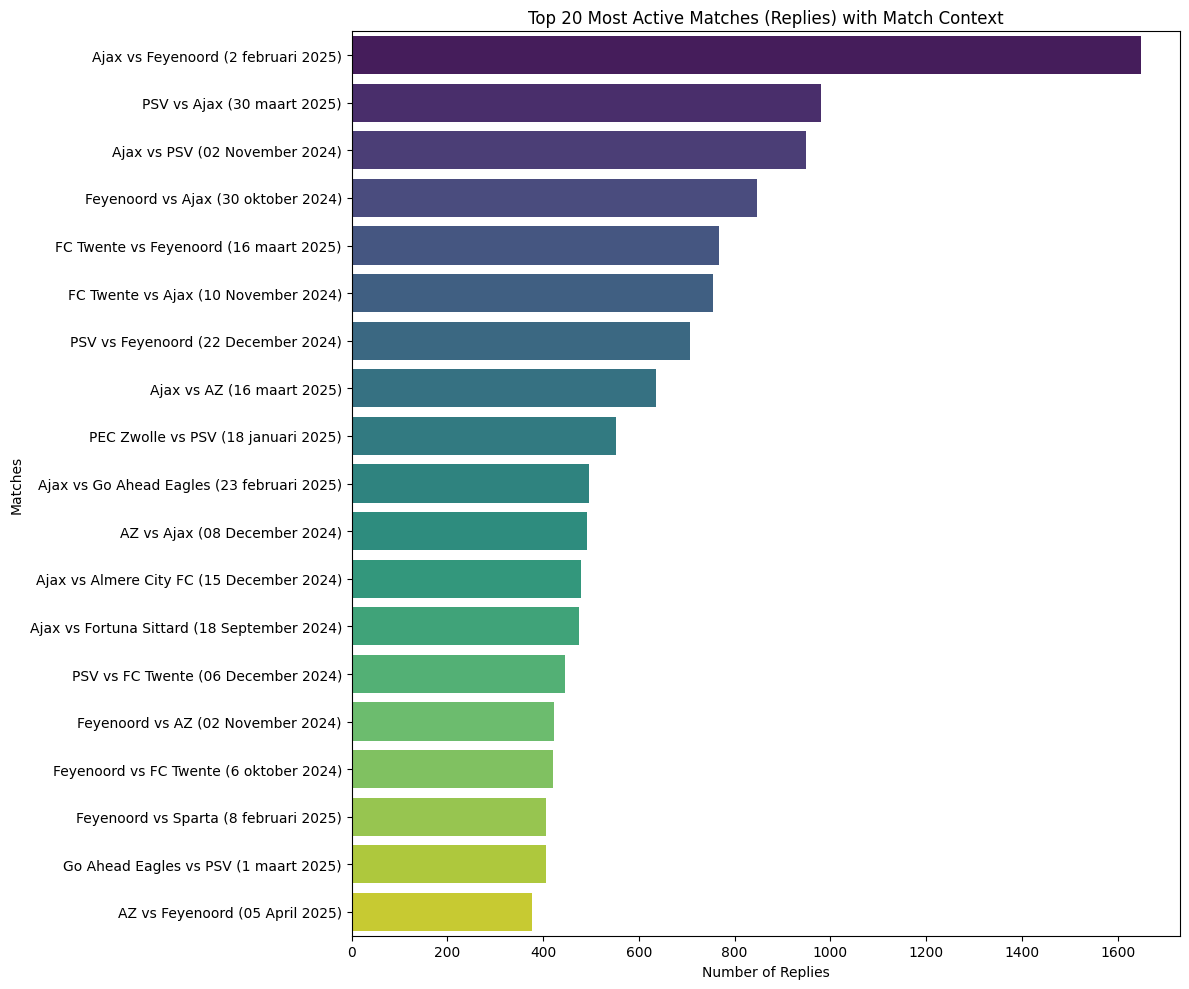

In [ ]:
# ==============================================
# Step 6: Top 20 matches with most replies 
# ==============================================

# Preparing the data for the improved chart
match_counts = df['match_id'].value_counts().head(20)
top_matches = df[df['match_id'].isin(match_counts.index)]

# Merging with the metadata to get match details
top_matches = top_matches.merge(
    match_metadata[['match_id', 'home_team', 'away_team', 'date']], 
    on='match_id', 
    how='left'
)

# Creating a descriptive label for each match
top_matches['match_label'] = top_matches['home_team'] + " vs " + top_matches['away_team'] + " (" + top_matches['date'] + ")"

# Creating a dictionary to map match IDs to their full labels
match_labels_mapping = top_matches.set_index('match_id')['match_label'].to_dict()
match_labels = [match_labels_mapping.get(match, match) for match in match_counts.index]

# Plotting the improved bar chart
plt.figure(figsize=(12, 10))
sns.barplot(y=match_labels, x=match_counts.values, palette="viridis")
plt.title("Top 20 Most Active Matches (Replies) with Match Context")
plt.xlabel("Number of Replies")
plt.ylabel("Matches")
plt.tight_layout()
plt.show()

## Analyze tweet length distribution (characters)

This step examines how long tweets typically are by calculating the number of characters per message. The distribution is visualized using a histogram to identify common tweet lengths and detect outliers.

Understanding the character-level length of tweets is useful for setting model input limits and identifying patterns in short vs. long content, especially when classifying toxicity later in the pipeline.


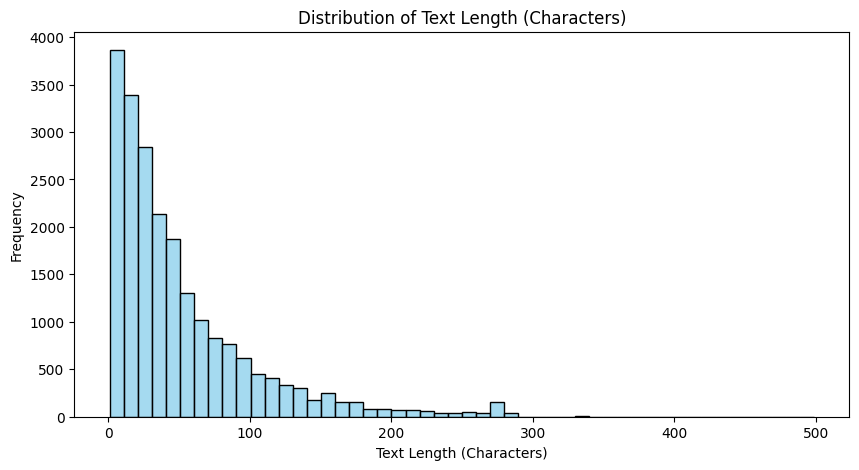

In [ ]:
# ==============================================
# Step 7: Distribution of tweet text length (characters)
# ==============================================

# Text length distribution (characters)
df['text_length'] = df['text'].astype(str).apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(df['text_length'], bins=50, color='skyblue')
plt.title("Distribution of Text Length (Characters)")
plt.xlabel("Text Length (Characters)")
plt.ylabel("Frequency")
plt.show()

## Analyze tweet length distribution (words)

In addition to character length, this step measures the number of words per tweet. The distribution is plotted to provide insight into how verbose users are when posting replies or original content.

Word count is a useful feature when evaluating tweet complexity and linguistic patterns. It also supports downstream tasks such as tokenization and model input management.

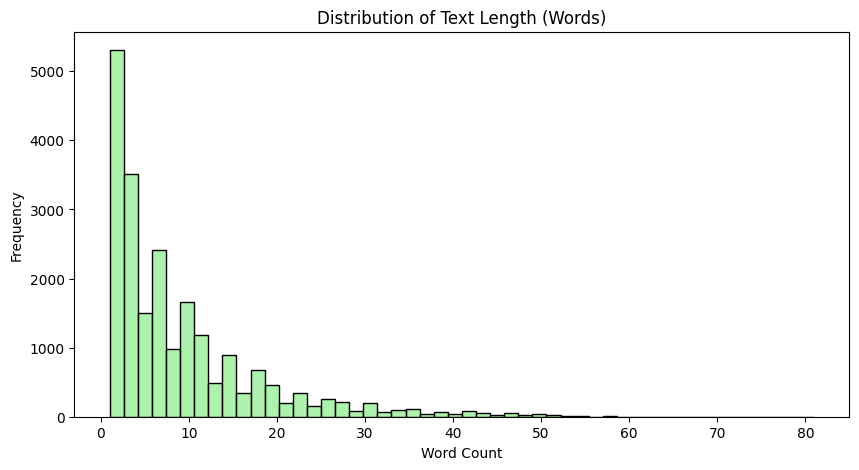

In [ ]:
# ==============================================
# Step 8: Distribution of tweet text length (words)
# ==============================================

# Text length distribution (words)
df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], bins=50, color='lightgreen')
plt.title("Distribution of Text Length (Words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

## Identify the most active users in reply threads

This step focuses on user participation by analyzing replies at thread depths 1 and 2 — replies to club tweets and replies to other users, respectively.

The top 20 most active users are visualized based on the number of replies they posted. This information provides early insight into which users are most vocal in discussions, which may later relate to patterns of toxic behavior or influence in the network.


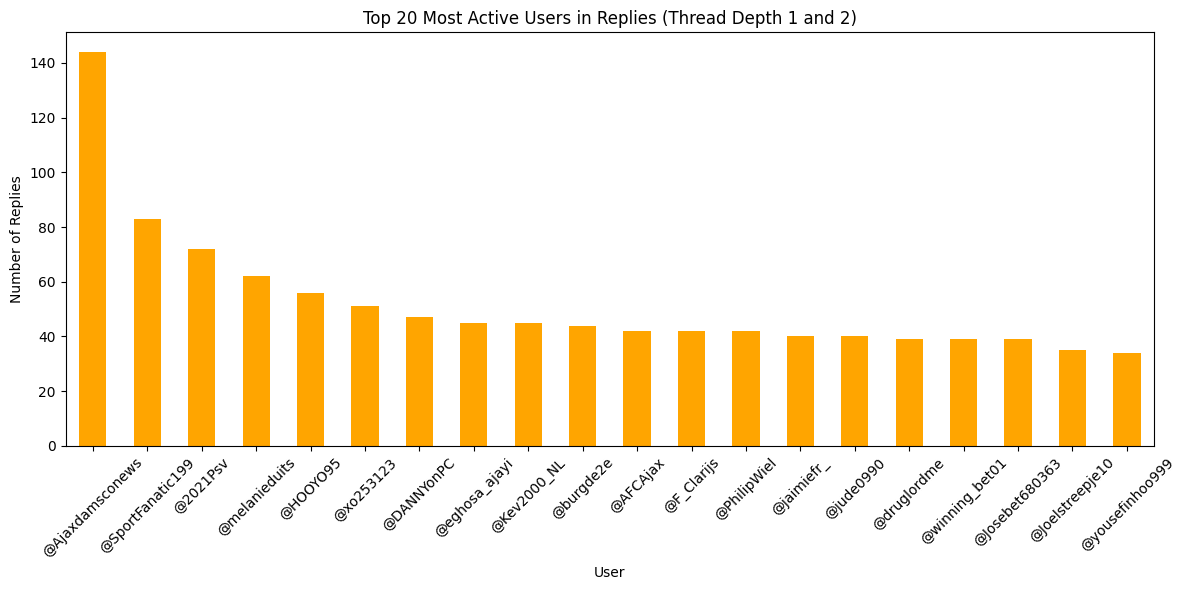

In [ ]:
# ==============================================
# Step 9: Top 20 most active users in replies 
# ==============================================

# Filtering for user replies (thread depth = 1 and 2)
user_replies = df[df['thread_depth'].isin([1, 2])]

# Counting the most active users in replies
plt.figure(figsize=(12, 6))
user_replies['author'].value_counts().head(20).plot(kind='bar', color='orange')
plt.title("Top 20 Most Active Users in Replies (Thread Depth 1 and 2)")
plt.xlabel("User")
plt.ylabel("Number of Replies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Prepare data for language detection

Before applying any language-specific models, it is necessary to separate tweets by type:

- Replies (thread depth 1 and 2) are selected for language detection, as these are user-generated and likely to be multilingual.
- Original tweets from official club accounts (thread depth 0) are excluded from this step since they are known to be Dutch and do not require detection.

This preparation ensures that language detection focuses only on user replies, which are more varied and less predictable in language use.


In [ ]:
# ==============================================
# Step 10: Prepare replies and original tweets for language detection
# ==============================================

# Get only the replies for language detection
replies = df[df["thread_depth"].isin([1, 2])].copy()

print(f"Total replies for language detection: {len(replies)}")

# Get the original tweets (Layer 0) without language detection
layer_0_df = df[df["thread_depth"] == 0].copy()

# Displaying the total number of original tweets
print(f"Total original tweets (Layer 0): {len(layer_0_df)}")

Total replies for language detection: 16701
Total original tweets (Layer 0): 4927


## Detect language of user replies

To ensure that toxicity detection is applied only to relevant content, language detection is performed on all user replies (thread depth 1 and 2). Since the toxicity classifier used later is trained on Dutch data, it is essential to filter out non-Dutch messages to avoid misclassification.

Two helper functions are defined for this step:
1. `clean_text_for_lang_detection()` — removes noise such as special characters, mentions, hashtags, and URLs to improve the accuracy of detection.
2. `detect_language_safe()` — applies the `langdetect` library to cleaned text while handling exceptions and skipping inputs that are too short to classify reliably.

The detected language is stored in a new column, `lang`. A distribution of the detected languages is printed to provide an overview of the multilingual nature of the dataset. While most replies are in Dutch (`nl`), the results also include English, Afrikaans, and other languages, as well as some entries marked as `unknown`.

This step provides a critical foundation for applying language-specific toxicity classifiers in subsequent stages.

In [ ]:
# ==============================================
# Step 11: Language detection on user replies
# =============================================

DetectorFactory.seed = 42  # Ensure reproducibility

# Function to clean text for language detection
def clean_text_for_lang_detection(text):
    if pd.isna(text) or len(str(text).strip()) == 0:
        return ""
    text = re.sub(r'[^\w\s,.!?@#]', '', text)  # Remove special characters
    text = re.sub(r'@\w+', '', text)           # Remove mentions
    text = re.sub(r'#\w+', '', text)           # Remove hashtags
    text = re.sub(r'http\S+', '', text)        # Remove URLs
    return re.sub(r'\s+', ' ', text).strip()

# Function for safe language detection
def detect_language_safe(text):
    try:
        cleaned = clean_text_for_lang_detection(text)
        if len(cleaned) < 10:
            return "unknown"
        return detect(cleaned)
    except LangDetectException:
        return "unknown"

# Applying language detection to each reply
replies["lang"] = replies["text"].apply(detect_language_safe)

# Displaying the distribution of detected languages
lang_counts = replies["lang"].value_counts()
print("Language distribution:\n", lang_counts)

Language distribution:
 nl         7216
unknown    3687
en         2097
af         1231
de          411
id          276
es          195
so          182
no          172
da          115
tl           95
pt           91
it           90
fi           90
fr           87
tr           80
et           80
pl           74
ca           45
sl           42
sw           41
ro           40
cy           38
sv           32
hr           32
hu           25
vi           24
ar           23
sk           19
lt           16
sq           15
cs           11
ja            9
lv            8
he            6
ko            2
fa            1
mk            1
el            1
zh-cn         1
Name: lang, dtype: int64


## Inspect replies labeled as Afrikaans

During language detection, a noticeable number of replies are labeled as Afrikaans (`af`). Since Dutch and Afrikaans are linguistically similar, short Dutch tweets are occasionally misclassified as Afrikaans by the language detector.

To assess whether these labels are accurate or require correction, a random sample of 20 tweets labeled as Afrikaans is displayed for manual inspection. Most of these messages are found to be written in Dutch, confirming that misclassification is occurring due to text brevity or spelling overlap.

This manual check supports the decision to reclassify Afrikaans-labeled messages as Dutch in the following step, ensuring that relevant content is not excluded from toxicity detection.


In [ ]:
# ==============================================
# Step 12: Inspect tweets labeled as Afrikaans
# ==============================================

# Displaying a sample of texts labeled as Afrikaans (af)
afrikaans_texts = replies[replies['lang'] == 'af']
print(f"Number of texts labeled as Afrikaans (af): {len(afrikaans_texts)}")

# Showing a random sample of 20 texts labeled as Afrikaans
afrikaans_texts_sample = afrikaans_texts[['text']].sample(20, random_state=42)
display(afrikaans_texts_sample)

Number of texts labeled as Afrikaans (af): 1231


,text
9847,Peer was erg goed vandaag. Sterk spelend en 2 ...
18078,Die assist😮‍💨😮‍💨
4471,"Kayky inbrengen, hard nodig."
9943,Hahahaa wat is dit nou weer dan. Morgen gewoon...
20341,Lekkker 2e plek boys topseizoen 💪🏼💪🏼
15651,Jaloerssssss?!
12697,Dit gaat Makkelie worden Calimero.
9522,Waarom van der boomen?
1865,goeie roggel op dat logo
2259,Gooi die hekken open dan


## Reclassify Afrikaans-labeled tweets as Dutch

Based on the manual inspection in the previous step, tweets labeled as Afrikaans (`af`) are reclassified as Dutch (`nl`). This adjustment is necessary because many short Dutch replies are incorrectly identified as Afrikaans due to linguistic similarities and limited context.

This correction ensures that Dutch-language content is not mistakenly excluded from downstream toxicity classification.

In [ ]:
# ==============================================
# Step 13: Reclassify Afrikaans tweets as Dutch
# ==============================================

# Reclassifying all Afrikaans texts as Dutch
replies.loc[replies['lang'] == 'af', 'lang'] = 'nl'
print("All 'af' entries have been reclassified to 'nl' (Dutch).")

All 'af' entries have been reclassified to 'nl' (Dutch).


## Visualize corrected language distribution

After reclassifying Afrikaans tweets as Dutch, the distribution of detected languages is recalculated and visualized. This bar chart provides a clear overview of the dominant languages in the reply dataset.

Most replies are now correctly identified as either Dutch (`nl`) or English (`en`), with smaller portions in other languages or marked as `unknown`. This confirmation step ensures that language detection and correction were successful before filtering the dataset for language-specific toxicity classification.


Corrected Language Distribution:
 nl         8447
unknown    3687
en         2097
de          411
id          276
es          195
so          182
no          172
da          115
tl           95
pt           91
it           90
fi           90
fr           87
tr           80
et           80
pl           74
ca           45
sl           42
sw           41
ro           40
cy           38
sv           32
hr           32
hu           25
vi           24
ar           23
sk           19
lt           16
sq           15
cs           11
ja            9
lv            8
he            6
ko            2
fa            1
mk            1
el            1
zh-cn         1
Name: lang, dtype: int64


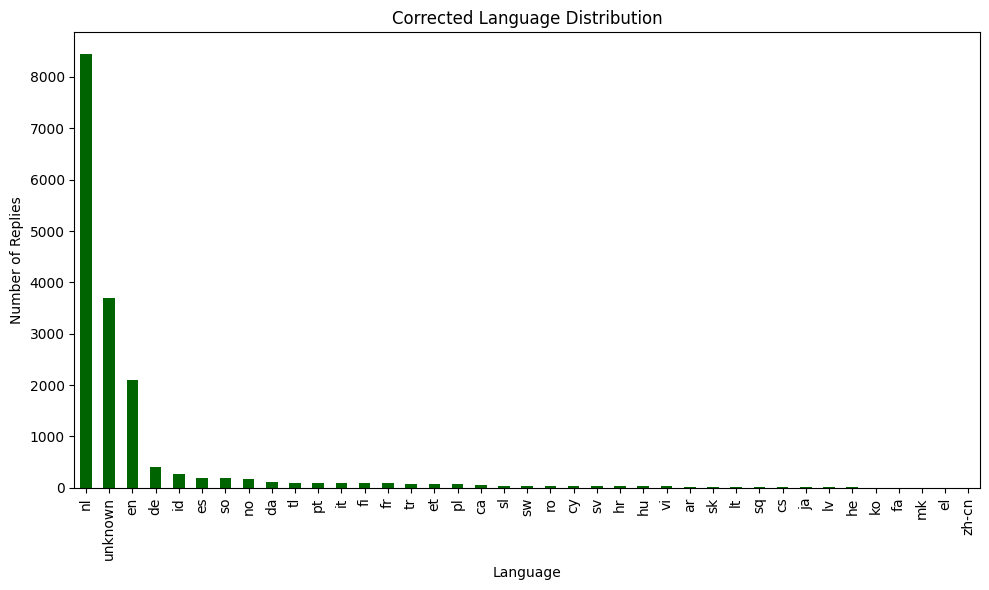

In [ ]:
# ==============================================
# Step 14: Visualize corrected language distribution
# ==============================================

# Displaying the corrected language distribution
corrected_lang_counts = replies['lang'].value_counts()
print("Corrected Language Distribution:\n", corrected_lang_counts)

# Visualizing the corrected language distribution
plt.figure(figsize=(10, 6))
corrected_lang_counts.plot(kind='bar', color='darkgreen')
plt.title("Corrected Language Distribution")
plt.xlabel("Language")
plt.ylabel("Number of Replies")
plt.tight_layout()
plt.show()

## Filter dataset for Dutch and English replies

To prepare for language-specific toxicity classification, the dataset is split into three subsets based on the detected language:

- `nl_df`: replies identified as Dutch (`nl`)
- `en_df`: replies identified as English (`en`)
- `other_lang_df`: replies in other languages or marked as `unknown`

Only the Dutch and English subsets are used for automated toxicity detection, as they align with the available pre-trained models. Replies in other languages are retained for completeness but are excluded from model inference due to lack of reliable support.

This filtering step ensures that each reply is processed by a language-appropriate classifier, minimizing the risk of mislabeling.


In [ ]:
# ==============================================
# Step 15: Filter dataset for Dutch and English replies
# ==============================================

# Creating the final filtered NLP dataset (Dutch and English only)
nlp_df = replies[replies["lang"].isin(["nl", "en"])].copy()

# Displaying the filtered dataset shape
print(f"Filtered NLP dataset shape (Dutch and English): {nlp_df.shape}")
print(nlp_df["lang"].value_counts())

# Splitting the filtered dataset
nl_df = nlp_df[nlp_df["lang"] == "nl"].copy()
en_df = nlp_df[nlp_df["lang"] == "en"].copy()

# Creating a separate dataframe for all other languages
other_lang_df = replies[~replies["lang"].isin(["nl", "en"])].copy()

# Displaying the counts for each split
print("\nSplit summary:")
print(f"Dutch (nl): {len(nl_df)} rows")
print(f"English (en): {len(en_df)} rows")
print(f"Other languages: {len(other_lang_df)} rows")

Filtered NLP dataset shape (Dutch and English): (10544, 16)
nl    8447
en    2097
Name: lang, dtype: int64

Split summary:
Dutch (nl): 8447 rows
English (en): 2097 rows
Other languages: 6157 rows


## Export Dutch dataset for manual labeling

To enable supervised model training, a subset of Dutch-language tweets is exported for manual annotation. This dataset includes:
- The tweet text
- A detected language column (`nl`)
- Two empty columns: `offensive_manual` and `abusive_manual`

### Labeling process

From a total of 8,447 Dutch-language replies, a stratified sample of **500 tweets** was manually labeled by the researcher (author of this thesis). Each tweet was reviewed and labeled using binary indicators:
- `1` = offensive or abusive content is present
- `0` = content is not offensive or abusive

Labeling was performed based on guidance from the **GroNLP project** and Dutch-language toxicity literature, focusing on intent, tone, and contextual cues.

### Limitations & Opportunities for Improvement

- **Single annotator**: Manual labeling was performed by one person, which may introduce bias or subjectivity. Reliability could be improved by involving multiple annotators and measuring inter-rater agreement (e.g., Cohen’s Kappa).
- **Limited sample**: Only ~6% of the dataset was labeled due to time constraints. Future improvements could involve scaling this process or applying active learning to focus on uncertain or diverse cases.

The manually labeled subset is used to fine-tune domain-adapted Dutch toxicity classifiers in later steps.


In [ ]:
# ==============================================
# Step 16: Export Dutch dataset for manual labeling
# ==============================================

# Always include these
cols = ["text", "lang"]

# Final column list
final_cols = cols 

# Build the export DataFrame
label_export = nl_df[final_cols].copy()

# Add empty manual label columns
label_export["offensive_manual"] = ""
label_export["abusive_manual"] = ""

# Shuffle for randomness
label_export = label_export.sample(frac=1, random_state=42).reset_index(drop=True)

# Save to CSV
label_export.to_csv("C:/Master/Master project/dutch_manual_labeling.csv", index=False, encoding="utf-8-sig")
print("CSV saved: dutch_manual_labeling.csv")

CSV saved: dutch_manual_labeling.csv


## Apply pre-trained Dutch toxicity models to label replies

This step applies two pre-trained Dutch BERT models developed by the GroNLP research group at the University of Groningen:

- [`GroNLP/bert_dutch_base_offensive_language`](https://huggingface.co/GroNLP/bert_dutch_base_offensive_language) — for detecting offensive content
- [`GroNLP/bert_dutch_base_abusive_language`](https://huggingface.co/GroNLP/bert_dutch_base_abusive_language) — for detecting abusive content

Both models are based on BERTje (de Vries et al., 2019), a Dutch adaptation of the BERT architecture trained on diverse Dutch-language corpora. The classifiers were fine-tuned on Dutch social media datasets annotated for various types of toxicity.

> de Vries, W., van Cranenburgh, A., Nissim, M., & de Jong, F. (2019). BERTje: A Dutch BERT Model. *arXiv preprint arXiv:1912.09582*. [https://arxiv.org/abs/1912.09582](https://arxiv.org/abs/1912.09582)

Each model outputs a probability score for `LABEL_1` (toxic class). To convert these scores into binary toxicity labels, a probability threshold of **0.7** is applied. This threshold was chosen based on manual inspection and early experimentation. It reflects a conservative trade-off — aiming for high precision while still capturing clearly toxic tweets. The goal is to minimize false positives without losing meaningful toxic content that could influence the network dynamics studied later in the pipeline.

The resulting binary label (`toxicity_label_from_prob_base`) serves as a baseline classifier output before applying any domain-specific fine-tuning.


In [ ]:
# ==============================================
# Step 17: Load Dutch classification models and generate toxicity scores
# ==============================================

# Load models and tokenizers
off_model_name = "GroNLP/bert_dutch_base_offensive_language"
abuse_model_name = "GroNLP/bert_dutch_base_abusive_language"

off_tokenizer = AutoTokenizer.from_pretrained(off_model_name)
off_model = AutoModelForSequenceClassification.from_pretrained(off_model_name)
abuse_tokenizer = AutoTokenizer.from_pretrained(abuse_model_name)
abuse_model = AutoModelForSequenceClassification.from_pretrained(abuse_model_name)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
off_model.to(device)
abuse_model.to(device)

# Helper to get LABEL_1 probability
def get_label1_probs(texts, tokenizer, model):
    probs = []
    model.eval()
    with torch.no_grad():
        for text in tqdm(texts):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
            logits = model(**inputs).logits
            softmax = F.softmax(logits, dim=1)
            prob_label1 = softmax[0, 1].item()
            probs.append(prob_label1)
    return probs

# Run on your dataset
texts = nl_df["text"].tolist()
nl_df["offensive_prob_base"] = get_label1_probs(texts, off_tokenizer, off_model)
nl_df["abusive_prob_base"] = get_label1_probs(texts, abuse_tokenizer, abuse_model)

# Create new toxicity label based on threshold on actual toxic probabilities
threshold = 0.7
nl_df["toxicity_label_from_prob_base"] = (
    (nl_df["offensive_prob_base"] >= threshold) | 
    (nl_df["abusive_prob_base"] >= threshold)
).astype(int)

c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 8447/8447 [05:11<00:00, 27.16it/s]


## Inspect toxicity probabilities and baseline labels

This step summarizes the results of the pre-trained Dutch models applied in the previous stage:

- Descriptive statistics are shown for both offensive and abusive probability scores, providing insight into how often the models detect potential toxicity.
- The binary label distribution (`toxicity_label_from_prob_base`) is also reported to quantify how many replies are flagged as toxic based on the 0.7 threshold.

These diagnostics help evaluate the behavior of the baseline classifiers and inform the design of a more tailored, fine-tuned model in subsequent steps.


In [ ]:
# ==============================================
# Step 18: Inspect model prediction distributions and toxicity labels
# ==============================================

# Check probability ranges
print("Offensive probability stats:")
print(nl_df["offensive_prob_base"].describe())

print("\nAbusive probability stats:")
print(nl_df["abusive_prob_base"].describe())

# Check final label counts
print("\nFinal toxicity label (from probability threshold) distribution:")
print(nl_df["toxicity_label_from_prob_base"].value_counts())

Offensive probability stats:
count    8447.000000
mean        0.236368
std         0.408478
min         0.000049
25%         0.000183
50%         0.000612
75%         0.235675
max         0.999967
Name: offensive_prob_base, dtype: float64

Abusive probability stats:
count    8447.000000
mean        0.120770
std         0.305509
min         0.000077
25%         0.000216
50%         0.000439
75%         0.003178
max         0.999753
Name: abusive_prob_base, dtype: float64

Final toxicity label (from probability threshold) distribution:
0    6452
1    1995
Name: toxicity_label_from_prob_base, dtype: int64


## Preview tweets classified as toxic by baseline models

To better understand what the baseline models are labeling as toxic, this step displays the top 10 replies with the highest combined toxicity scores.

Tweets are sorted by their offensive and abusive probability scores, both derived from the pre-trained Dutch classifiers. Reviewing these examples helps verify whether high-confidence predictions align with real-world expectations of toxic content.

This qualitative inspection also supports early assessment of model precision before investing in supervised fine-tuning.

In [ ]:
# ==============================================
# Step 19: Preview top classified toxic tweets
# ==============================================

nl_df[
    (nl_df["toxicity_label_from_prob_base"] == 1)
].sort_values(["offensive_prob_base", "abusive_prob_base"], ascending=False)[["text", "offensive_prob_base", "abusive_prob_base"]].head(10)

,text,offensive_prob_base,abusive_prob_base
18947,En jullie gaan gewoon blind akkord met de 3 fa...,0.999967,0.997844
15626,Weghorst die het viert alsof hij verantwoordel...,0.999966,0.999661
12097,Dankzij en stel idioten met een paar hersencel...,0.999966,0.999621
67,Haal nog maar wat Nederlanders in plaats van e...,0.999965,0.999511
20199,Niet zo Mokken its so Fokking irritant:reactie...,0.999965,0.998147
9607,"Laat ze nou eens met inzet VOORUIT voetballen,...",0.999965,0.345846
20338,Die psv-ers zijn zo zielig he. Janken over de ...,0.999964,0.999511
20326,🤣🤣🤣wat een slechte verliezers die kut lampies ...,0.999964,0.998228
14442,Dit is wel echt weer tering dom,0.999964,0.978755
11323,Wat een waardeloos Feyenoord. Wat een stelletj...,0.999964,0.999519


## Inspect borderline toxic predictions (scores below 0.8)

This step samples 20 replies that were labeled as toxic by the baseline models but have relatively moderate probability scores (below 0.8). These are considered borderline cases that lie closer to the 0.7 classification threshold.

Examining these examples is important for evaluating how sensitive the threshold is and whether slightly lower scores may still reflect harmful content — or if some misclassifications are occurring.

These insights help refine threshold choices and justify the need for manual annotations or fine-tuning.


In [ ]:
# ==============================================
# Step 20: Sample borderline toxic tweets (score < 0.8)
# ==============================================

nl_df[
    (nl_df["toxicity_label_from_prob_base"] == 1) &
    (nl_df[["offensive_prob_base", "abusive_prob_base"]].max(axis=1) < 0.8)
][["text", "offensive_prob_base", "abusive_prob_base"]].sample(20, random_state=1)

,text,offensive_prob_base,abusive_prob_base
13081,Is er een journalist die na de wedstrijd kan v...,0.790791,0.005074
1280,Alweer!!! Dat is toch een kwalijke zaak!,0.702886,0.008453
12224,Misschien moet je dan aan de poort maar eens b...,0.712918,0.001393
21163,Zonder dat 'kkr' eens,0.730628,0.000895
15527,Mis! Karma … 100% erbuiten,0.050559,0.758479
13525,Waardeloos. Vooral de instelling waarmee de me...,0.752290,0.001775
19276,Beetje op een trommel tikken terwijl je zelf e...,0.765164,0.000407
16756,"Zo is dat, eerst 2-0 achter komen en dan thori...",0.766501,0.010463
14054,"Mees Hilghers meet Calvin Verdonk. Good luck, ...",0.759405,0.003293
7889,Wat is dit voor thuisfluiter?,0.705838,0.738813


## Fine-tune Dutch toxicity classifiers using manual labels

To improve model performance on Eredivisie-specific language and tone, this step fine-tunes Dutch toxicity models using manually labeled data. The process includes:

1. **Loading the annotated dataset**: Human-labeled offensive and abusive columns are merged into a single binary label `toxicity_manual`.
2. **Splitting the data**: The dataset is split into training and validation sets using stratified sampling.
3. **Tokenization and preprocessing**: Tweets are tokenized using the appropriate model tokenizer, and data is converted to PyTorch tensors.
4. **Model training**: A custom training loop is used with class weighting to address label imbalance. Models are trained and evaluated using F1-score on the validation set.
5. **Grid search**: Multiple learning rates, batch sizes, and epoch counts are tested. The best model checkpoint (highest F1) is selected and saved.

This supervised fine-tuning produces two domain-adapted Dutch classifiers — one for offensive and one for abusive language — customized for the specific toxicity patterns observed in the dataset.

The models fine-tuned here are based on GroNLP's public Dutch toxicity classifiers, which were originally trained on Dutch social media data. See:
- HuggingFace model hub: [GroNLP on HuggingFace](https://huggingface.co/GroNLP)
- Original architecture: BERTje (de Vries et al., 2019)


In [ ]:
# ==============================================
# Step 21: Load manual labels and fine-tune Dutch toxicity models (grid search)
# ==============================================

# === Load manually labeled dataset ===
path = "C:/Master/Master project/dutch_manual_labelingV2.csv"
labeled_df = pd.read_csv(path, encoding="utf-8-sig", engine="python")

# Combine offensive and abusive labels
labeled_df["toxicity_manual"] = (
    (labeled_df["offensive_manual"] == 1) | (labeled_df["abusive_manual"] == 1)
).astype(int)

# Filter only rows with actual labels
labeled_df_filtered = labeled_df.dropna(
    subset=["offensive_manual", "abusive_manual"], how="all"
).copy()

# Base path
pickle_dir = "C:/Master/Master project/"

# Tokenization function
def tokenize_data(df, tokenizer):
    texts = df["text"].tolist()
    labels = df["toxicity_manual"].tolist()
    encodings = tokenizer(
        texts, padding=True, truncation=True, max_length=128, return_tensors="pt"
    )
    return TensorDataset(encodings["input_ids"], encodings["attention_mask"], torch.tensor(labels))

# Load or create tokenized datasets
def load_or_create_datasets(filename, tokenizer):
    filepath = os.path.join(pickle_dir, filename)
    if os.path.exists(filepath):
        print(f"Loading datasets from {filepath}...")
        with open(filepath, "rb") as f:
            return pickle.load(f)

    print(f"Creating new datasets and saving to {filepath}...")
    train_df, val_df = train_test_split(
        labeled_df_filtered[["text", "toxicity_manual"]],
        test_size=0.2,
        random_state=42,
        stratify=labeled_df_filtered["toxicity_manual"]
    )
    train_dataset = tokenize_data(train_df, tokenizer)
    val_dataset = tokenize_data(val_df, tokenizer)

    with open(filepath, "wb") as f:
        pickle.dump((train_dataset, val_dataset), f)

    return train_dataset, val_dataset

# Weighted training function with best model selection
def train_model(model, train_loader, val_loader, lr, num_epochs, class_weights):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
    optimizer = AdamW(model.parameters(), lr=lr)

    best_f1 = 0
    best_state = None

    for epoch in range(num_epochs):
        model.train()
        for input_ids, attention_mask, labels in train_loader:
            input_ids, attention_mask, labels = (
                input_ids.to(device), attention_mask.to(device), labels.to(device)
            )
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for input_ids, attention_mask, labels in val_loader:
                input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.numpy())

        f1 = f1_score(all_labels, all_preds)
        print(f"Epoch {epoch+1}/{num_epochs} - F1: {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_state = model.state_dict()

    model.load_state_dict(best_state)
    return model

# === Grid search logic with class weighting and best model saving ===
param_grid = {
    "learning_rate": [1e-5, 2e-5, 3e-5],
    "batch_size": [8, 16],
    "num_epochs": [3, 5],
}

def grid_search_and_save(model_name, tokenizer_name, dataset_filename, model_save_path):
    filepath = os.path.join(pickle_dir, model_save_path)
    if os.path.exists(filepath):
        print(f"Model already exists at {filepath}. Skipping grid search.")
        return

    print(f"\nGrid Search for {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    train_dataset, val_dataset = load_or_create_datasets(dataset_filename, tokenizer)

    # Compute class weights based on filtered data
    label_counts = labeled_df_filtered["toxicity_manual"].value_counts().sort_index()
    weight_non_toxic = 1.0
    weight_toxic = label_counts[0] / label_counts[1]
    class_weights = [weight_non_toxic, weight_toxic]

    best_model = None
    best_f1 = 0

    for params in ParameterGrid(param_grid):
        print(f"\nTraining with params: {params}")
        train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=params["batch_size"])

        model = AutoModelForSequenceClassification.from_pretrained(
            tokenizer_name, num_labels=2
        ).to("cuda" if torch.cuda.is_available() else "cpu")

        model = train_model(
            model, train_loader, val_loader,
            lr=params["learning_rate"],
            num_epochs=params["num_epochs"],
            class_weights=class_weights
        )

        # Final validation to save the best model
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for input_ids, attention_mask, labels in val_loader:
                input_ids, attention_mask = input_ids.to(model.device), attention_mask.to(model.device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.numpy())

        f1 = f1_score(all_labels, all_preds)
        print(f"Validation F1 for current model: {f1:.4f}")
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_tokenizer = tokenizer

    # Save best model and tokenizer
    print(f"\nSaving best model with F1 = {best_f1:.4f} to {filepath}")
    os.makedirs(filepath, exist_ok=True)
    best_model.save_pretrained(filepath)
    best_tokenizer.save_pretrained(filepath)

# Run training for both classifiers
grid_search_and_save(
    model_name="Offensive Model",
    tokenizer_name="GroNLP/bert_dutch_base_offensive_language",
    dataset_filename="offensive_datasets.pkl",
    model_save_path="best_fine_tuned_offensive"
)

grid_search_and_save(
    model_name="Abusive Model",
    tokenizer_name="GroNLP/bert_dutch_base_abusive_language",
    dataset_filename="abusive_datasets.pkl",
    model_save_path="best_fine_tuned_abusive"
)


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Grid Search for Offensive Model...
Loading datasets from C:/Master/Master project/offensive_datasets.pkl...

Training with params: {'batch_size': 8, 'learning_rate': 1e-05, 'num_epochs': 3}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - F1: 0.6122
Epoch 2/3 - F1: 0.5769
Epoch 3/3 - F1: 0.5769
Validation F1 for current model: 0.5769

Training with params: {'batch_size': 8, 'learning_rate': 1e-05, 'num_epochs': 5}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - F1: 0.6102
Epoch 2/5 - F1: 0.6182
Epoch 3/5 - F1: 0.6182
Epoch 4/5 - F1: 0.5902
Epoch 5/5 - F1: 0.5862
Validation F1 for current model: 0.5862

Training with params: {'batch_size': 8, 'learning_rate': 2e-05, 'num_epochs': 3}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - F1: 0.5902
Epoch 2/3 - F1: 0.6230
Epoch 3/3 - F1: 0.6071
Validation F1 for current model: 0.6071

Training with params: {'batch_size': 8, 'learning_rate': 2e-05, 'num_epochs': 5}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - F1: 0.5660
Epoch 2/5 - F1: 0.6000
Epoch 3/5 - F1: 0.5902
Epoch 4/5 - F1: 0.5714
Epoch 5/5 - F1: 0.6000
Validation F1 for current model: 0.6000

Training with params: {'batch_size': 8, 'learning_rate': 3e-05, 'num_epochs': 3}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - F1: 0.4727
Epoch 2/3 - F1: 0.5909
Epoch 3/3 - F1: 0.6154
Validation F1 for current model: 0.6154

Training with params: {'batch_size': 8, 'learning_rate': 3e-05, 'num_epochs': 5}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - F1: 0.5556
Epoch 2/5 - F1: 0.5479
Epoch 3/5 - F1: 0.5000
Epoch 4/5 - F1: 0.6000
Epoch 5/5 - F1: 0.5556
Validation F1 for current model: 0.5556

Training with params: {'batch_size': 16, 'learning_rate': 1e-05, 'num_epochs': 3}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - F1: 0.5763
Epoch 2/3 - F1: 0.5714
Epoch 3/3 - F1: 0.6182
Validation F1 for current model: 0.6182

Training with params: {'batch_size': 16, 'learning_rate': 1e-05, 'num_epochs': 5}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - F1: 0.5926
Epoch 2/5 - F1: 0.6102
Epoch 3/5 - F1: 0.6207
Epoch 4/5 - F1: 0.6071
Epoch 5/5 - F1: 0.6038
Validation F1 for current model: 0.6038

Training with params: {'batch_size': 16, 'learning_rate': 2e-05, 'num_epochs': 3}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - F1: 0.5176
Epoch 2/3 - F1: 0.5965
Epoch 3/3 - F1: 0.5424
Validation F1 for current model: 0.5424

Training with params: {'batch_size': 16, 'learning_rate': 2e-05, 'num_epochs': 5}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - F1: 0.5397
Epoch 2/5 - F1: 0.6182
Epoch 3/5 - F1: 0.5574
Epoch 4/5 - F1: 0.5763
Epoch 5/5 - F1: 0.5614
Validation F1 for current model: 0.5614

Training with params: {'batch_size': 16, 'learning_rate': 3e-05, 'num_epochs': 3}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - F1: 0.5000
Epoch 2/3 - F1: 0.5614
Epoch 3/3 - F1: 0.6129
Validation F1 for current model: 0.6129

Training with params: {'batch_size': 16, 'learning_rate': 3e-05, 'num_epochs': 5}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - F1: 0.5882
Epoch 2/5 - F1: 0.6182
Epoch 3/5 - F1: 0.6032
Epoch 4/5 - F1: 0.6429
Epoch 5/5 - F1: 0.6667
Validation F1 for current model: 0.6667

Saving best model with F1 = 0.6667 to C:/Master/Master project/best_fine_tuned_offensive

Grid Search for Abusive Model...


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Creating new datasets and saving to C:/Master/Master project/abusive_datasets.pkl...

Training with params: {'batch_size': 8, 'learning_rate': 1e-05, 'num_epochs': 3}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - F1: 0.5660
Epoch 2/3 - F1: 0.5172
Epoch 3/3 - F1: 0.5517
Validation F1 for current model: 0.5517

Training with params: {'batch_size': 8, 'learning_rate': 1e-05, 'num_epochs': 5}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - F1: 0.5538
Epoch 2/5 - F1: 0.5625
Epoch 3/5 - F1: 0.5660
Epoch 4/5 - F1: 0.5660
Epoch 5/5 - F1: 0.5769
Validation F1 for current model: 0.5769

Training with params: {'batch_size': 8, 'learning_rate': 2e-05, 'num_epochs': 3}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - F1: 0.5070
Epoch 2/3 - F1: 0.5283
Epoch 3/3 - F1: 0.5818
Validation F1 for current model: 0.5818

Training with params: {'batch_size': 8, 'learning_rate': 2e-05, 'num_epochs': 5}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - F1: 0.5556
Epoch 2/5 - F1: 0.6182
Epoch 3/5 - F1: 0.5763
Epoch 4/5 - F1: 0.5667
Epoch 5/5 - F1: 0.5455
Validation F1 for current model: 0.5455

Training with params: {'batch_size': 8, 'learning_rate': 3e-05, 'num_epochs': 3}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - F1: 0.5000
Epoch 2/3 - F1: 0.5217
Epoch 3/3 - F1: 0.5357
Validation F1 for current model: 0.5357

Training with params: {'batch_size': 8, 'learning_rate': 3e-05, 'num_epochs': 5}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - F1: 0.5085
Epoch 2/5 - F1: 0.5385
Epoch 3/5 - F1: 0.5185
Epoch 4/5 - F1: 0.5079
Epoch 5/5 - F1: 0.4923
Validation F1 for current model: 0.4923

Training with params: {'batch_size': 16, 'learning_rate': 1e-05, 'num_epochs': 3}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - F1: 0.5862
Epoch 2/3 - F1: 0.5625
Epoch 3/3 - F1: 0.5106
Validation F1 for current model: 0.5106

Training with params: {'batch_size': 16, 'learning_rate': 1e-05, 'num_epochs': 5}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - F1: 0.5818
Epoch 2/5 - F1: 0.5588
Epoch 3/5 - F1: 0.5556
Epoch 4/5 - F1: 0.5667
Epoch 5/5 - F1: 0.5818
Validation F1 for current model: 0.5818

Training with params: {'batch_size': 16, 'learning_rate': 2e-05, 'num_epochs': 3}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - F1: 0.4828
Epoch 2/3 - F1: 0.5079
Epoch 3/3 - F1: 0.5556
Validation F1 for current model: 0.5556

Training with params: {'batch_size': 16, 'learning_rate': 2e-05, 'num_epochs': 5}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - F1: 0.5769
Epoch 2/5 - F1: 0.5763
Epoch 3/5 - F1: 0.5614
Epoch 4/5 - F1: 0.5818
Epoch 5/5 - F1: 0.6038
Validation F1 for current model: 0.6038

Training with params: {'batch_size': 16, 'learning_rate': 3e-05, 'num_epochs': 3}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - F1: 0.6230
Epoch 2/3 - F1: 0.6333
Epoch 3/3 - F1: 0.5098
Validation F1 for current model: 0.5098

Training with params: {'batch_size': 16, 'learning_rate': 3e-05, 'num_epochs': 5}


c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - F1: 0.5128
Epoch 2/5 - F1: 0.5574
Epoch 3/5 - F1: 0.5763
Epoch 4/5 - F1: 0.5455
Epoch 5/5 - F1: 0.5455
Validation F1 for current model: 0.5455

Saving best model with F1 = 0.6038 to C:/Master/Master project/best_fine_tuned_abusive


## Evaluate fine-tuned Dutch offensive language model

After training, the fine-tuned offensive classifier is evaluated on the validation set to assess its performance. The following metrics are reported:

- **Accuracy**: overall correctness of predictions
- **Precision**: the proportion of predicted toxic tweets that are truly toxic
- **Recall**: the proportion of actual toxic tweets that are correctly identified
- **F1-score**: the harmonic mean of precision and recall

A detailed classification report is printed, along with a confusion matrix to visualize false positives and false negatives.

This evaluation helps determine whether the model generalizes well to unseen Dutch football-related tweets and whether further tuning is needed.

Accuracy:  0.8100
Precision: 0.7037
Recall:    0.6333
F1 Score:  0.6667

Detailed Classification Report:

              precision    recall  f1-score   support

   Non-toxic       0.85      0.89      0.87        70
       Toxic       0.70      0.63      0.67        30

    accuracy                           0.81       100
   macro avg       0.78      0.76      0.77       100
weighted avg       0.81      0.81      0.81       100



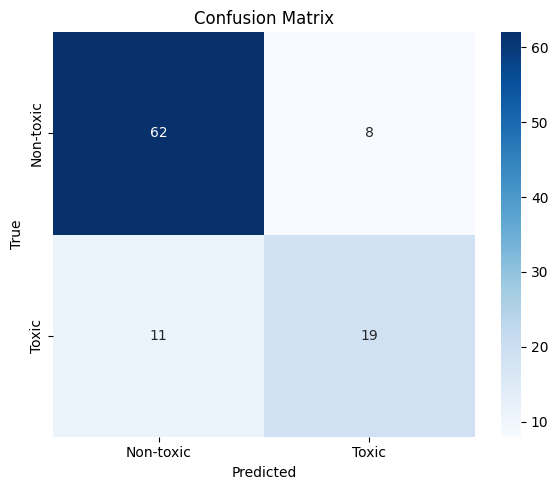

In [ ]:
# ==============================================
# Step 22: Evaluate fine-tuned offensive language model
# ==============================================

# Load tokenizer and model
model_path = "C:/Master/Master project/best_fine_tuned_offensive" 
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path).to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Load validation set again
with open("C:/Master/Master project/offensive_datasets.pkl", "rb") as f:
    _, val_dataset = pickle.load(f)

val_loader = DataLoader(val_dataset, batch_size=16)

# Run predictions on validation set
all_preds = []
all_labels = []

with torch.no_grad():
    for input_ids, attention_mask, labels in val_loader:
        input_ids = input_ids.to(model.device)
        attention_mask = attention_mask.to(model.device)
        labels = labels.to(model.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Classification report
print("\nDetailed Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=["Non-toxic", "Toxic"]))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-toxic", "Toxic"], yticklabels=["Non-toxic", "Toxic"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


## Evaluate fine-tuned Dutch abusive language model

This step evaluates the performance of the fine-tuned model for abusive language detection using the manually labeled validation set. The same metrics used in the offensive model evaluation are applied:

- **Accuracy**
- **Precision**
- **Recall**
- **F1-score**

In addition, a detailed classification report is generated, and a confusion matrix is plotted to visualize prediction outcomes.

Together with the offensive classifier, this model forms the core of the final toxicity detection system for Dutch-language football tweets.

Accuracy:  0.7900
Precision: 0.6957
Recall:    0.5333
F1 Score:  0.6038

Detailed Classification Report:
              precision    recall  f1-score   support

   Non-toxic       0.82      0.90      0.86        70
       Toxic       0.70      0.53      0.60        30

    accuracy                           0.79       100
   macro avg       0.76      0.72      0.73       100
weighted avg       0.78      0.79      0.78       100



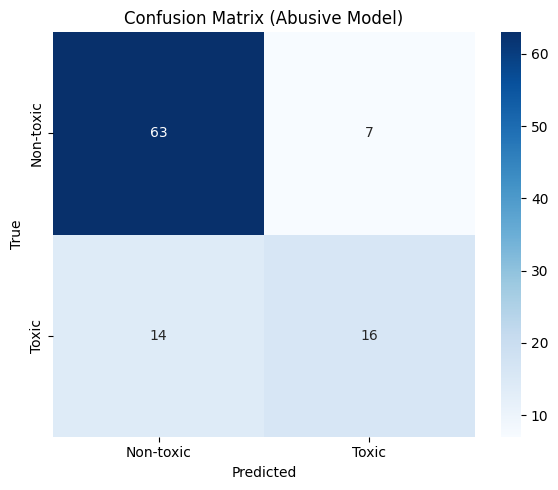

In [ ]:
# ==============================================
# Step 23: Evaluate fine-tuned abusive language model
# ==============================================

# Load abusive model and tokenizer
abuse_model_path = "C:/Master/Master project/best_fine_tuned_abusive"
abuse_tokenizer = AutoTokenizer.from_pretrained(abuse_model_path)
abuse_model = AutoModelForSequenceClassification.from_pretrained(abuse_model_path).to("cuda" if torch.cuda.is_available() else "cpu")
abuse_model.eval()

# Load validation data
with open("C:/Master/Master project/abusive_datasets.pkl", "rb") as f:
    _, val_dataset = pickle.load(f)

val_loader = DataLoader(val_dataset, batch_size=16)

# Evaluate abusive model
abuse_preds = []
abuse_labels = []

with torch.no_grad():
    for input_ids, attention_mask, labels in val_loader:
        input_ids = input_ids.to(abuse_model.device)
        attention_mask = attention_mask.to(abuse_model.device)
        labels = labels.to(abuse_model.device)

        outputs = abuse_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        abuse_preds.extend(preds.cpu().numpy())
        abuse_labels.extend(labels.cpu().numpy())

# Print metrics
accuracy = accuracy_score(abuse_labels, abuse_preds)
precision, recall, f1, _ = precision_recall_fscore_support(abuse_labels, abuse_preds, average="binary")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(abuse_labels, abuse_preds, target_names=["Non-toxic", "Toxic"]))

# Confusion matrix
conf_matrix = confusion_matrix(abuse_labels, abuse_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-toxic", "Toxic"], yticklabels=["Non-toxic", "Toxic"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Abusive Model)")
plt.tight_layout()
plt.show()


## Run final toxicity predictions on Dutch tweets using fine-tuned models

With both Dutch classifiers fine-tuned and evaluated, this step applies them to the entire Dutch-language dataset (`nl_df`) to generate final toxicity scores.

For each tweet:
- The **offensive** model returns a probability for offensive content.
- The **abusive** model returns a probability for abusive content.
- A binary toxicity label (`toxicity_label_nl`) is assigned if either probability exceeds the threshold of 0.7.

These predictions represent the final model-based toxicity labels for Dutch tweets and will be combined with English classification results in later steps.


In [ ]:
# ==============================================
# Step 24: Run final toxicity predictions on Dutch dataset using fine-tuned models
# ==============================================

# Load the best fine-tuned models and tokenizers
off_model_path = "./best_fine_tuned_offensive"
abuse_model_path = "./best_fine_tuned_abusive"

off_tokenizer = AutoTokenizer.from_pretrained(off_model_path)
off_model = AutoModelForSequenceClassification.from_pretrained(off_model_path)
abuse_tokenizer = AutoTokenizer.from_pretrained(abuse_model_path)
abuse_model = AutoModelForSequenceClassification.from_pretrained(abuse_model_path)

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
off_model.to(device)
abuse_model.to(device)
off_model.eval()
abuse_model.eval()

# Function to get probabilities and labels for new texts
def predict_texts_from_df(df):
    texts = df["text"].tolist()
    results = []

    with torch.no_grad():
        for text in tqdm(texts, desc="Evaluating Texts"):
            # Offensive Model Prediction
            off_inputs = off_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
            off_outputs = off_model(**off_inputs)
            off_probs = torch.softmax(off_outputs.logits, dim=1)
            off_prob = off_probs[0, 1].item()  # Probability of Label 1 (toxic)

            # Abusive Model Prediction
            abuse_inputs = abuse_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
            abuse_outputs = abuse_model(**abuse_inputs)
            abuse_probs = torch.softmax(abuse_outputs.logits, dim=1)
            abuse_prob = abuse_probs[0, 1].item()  # Probability of Label 1 (abusive)

            # Combine Results
            combined_toxicity = int((off_prob >= 0.7) or (abuse_prob >= 0.7))  # 0 or 1
            results.append({
                "text": text,
                "offensive_prob": round(off_prob, 4),
                "abusive_prob": round(abuse_prob, 4),
                "toxicity_label_nl": combined_toxicity
            })

    return pd.DataFrame(results)

print("\nMaking predictions on your DataFrame (nl_df)...")

# Run predictions and return results with matching index
results_df = predict_texts_from_df(nl_df)

# Merge on 'text' to align rows properly
nl_df = nl_df.merge(results_df, on="text", how="left")

display(nl_df.head())


Making predictions on your DataFrame (nl_df)...


Evaluating Texts: 100%|██████████| 8447/8447 [10:16<00:00, 13.70it/s]


,match_id,team_handle,thread_depth,thread_id,author,text,timestamp,tweet_url,parent_author,parent_url,...,original_parent_author,text_length,word_count,lang,offensive_prob_base,abusive_prob_base,toxicity_label_from_prob_base,offensive_prob,abusive_prob,toxicity_label_nl
0,M001,NACnl,2,https://nitter.net/420jasper_/status/182197233...,@EXFLRussell,bal via het bovenbeen op de arm is geen hands,2024-08-09 20:14:00+00:00,https://nitter.net/NACnl/status/18219720329193...,@420jasper_,https://nitter.net/420jasper_/status/182197233...,...,@420jasper_,45,10,nl,0.000608,0.000217,0,0.0185,0.0086,0
1,M001,NACnl,2,https://nitter.net/BigBalard/status/1821955757...,@Vigaltmedia,Hij kan zich melden bij de balie om te betalen.,2024-08-09 19:59:00+00:00,https://nitter.net/NACnl/status/18219546043195...,@BigBalard,https://nitter.net/BigBalard/status/1821955757...,...,@BigBalard,47,10,nl,0.000550,0.000314,0,0.0233,0.0064,0
2,M001,NACnl,2,https://nitter.net/Cetfy/status/18219782209396...,@GerriedeB,"Jeetje, wat een sneuneus ben jij zeg.",2024-08-09 18:50:00+00:00,https://nitter.net/NACnl/status/18219781499887...,@Cetfy,https://nitter.net/Cetfy/status/18219782209396...,...,@Cetfy,37,7,nl,0.999916,0.998894,1,0.9640,0.9922,1
3,M001,NACnl,2,https://nitter.net/MilanVelde9865/status/18219...,@AdriaanVanden14,Dat deden jullie daarvoor ook al,2024-08-09 21:02:00+00:00,https://nitter.net/NACnl/status/18219986011550...,@MilanVelde9865,https://nitter.net/MilanVelde9865/status/18219...,...,@MilanVelde9865,32,6,nl,0.000127,0.000196,0,0.0092,0.0069,0
4,M001,NACnl,1,https://nitter.net/NACnl/status/18218702279839...,@HEYHEYhupNAC,Zullen deze shirts ook verkocht worden?,2024-08-09 11:45:00+00:00,https://nitter.net/HEYHEYhupNAC/status/1821875...,@NACnl,https://nitter.net/NACnl/status/18218702279839...,...,@NACnl,39,6,nl,0.000084,0.000133,0,0.0084,0.0120,0


## Inspect final Dutch prediction scores and toxicity labels

This step provides a summary of the predictions generated by the fine-tuned Dutch models:

- Descriptive statistics are shown for both the offensive and abusive probability scores.
- The distribution of the final binary toxicity label (`toxicity_label_nl`) is displayed to understand how frequently tweets are classified as toxic.

This validation step helps ensure that the final predictions are within expected probability ranges and that the threshold is producing a reasonable balance between toxic and non-toxic labels.

In [ ]:
# ==============================================
# Step 25: Inspect final prediction probabilities and toxicity label distribution
# ==============================================

# Check probability ranges
print("Offensive probability stats:")
print(nl_df["offensive_prob"].describe())

print("\nAbusive probability stats:")
print(nl_df["abusive_prob"].describe())

# Check final label counts
print("\nFinal toxicity label (from probability threshold) distribution:")
print(nl_df["toxicity_label_nl"].value_counts())

Offensive probability stats:
count    10297.000000
mean         0.241909
std          0.380253
min          0.000600
25%          0.003600
50%          0.017700
75%          0.338800
max          0.999700
Name: offensive_prob, dtype: float64

Abusive probability stats:
count    10297.000000
mean         0.233750
std          0.361969
min          0.000900
25%          0.005400
50%          0.023900
75%          0.300400
max          0.998700
Name: abusive_prob, dtype: float64

Final toxicity label (from probability threshold) distribution:
0    7864
1    2433
Name: toxicity_label_nl, dtype: int64


## Clean up intermediate probability columns (Dutch)

After generating and inspecting the final toxicity labels, intermediate probability columns used during Dutch classification are no longer needed.

This step removes the following columns from the Dutch dataset:
- `offensive_prob_base`
- `abusive_prob_base`
- `offensive_prob`
- `abusive_prob`

This cleanup ensures that the dataset remains concise and ready for merging with English and other-language data in the next steps.

In [ ]:
# ==============================================
# Step 26: Drop intermediate probability columns
# ==============================================

# Dropping unnecessary columns
columns_to_drop = [
    "offensive_prob_base", "abusive_prob_base", "offensive_prob", "abusive_prob"
]

nl_df = nl_df.drop(columns=columns_to_drop, errors='ignore')

## Run toxicity detection on English tweets using pre-trained models

To classify English-language tweets, this step applies a set of pre-trained models available via HuggingFace, each targeting a specific form of toxicity:

- **Hate speech**: [`Hate-speech-CNERG/bert-base-uncased-hatexplain`](https://huggingface.co/Hate-speech-CNERG/bert-base-uncased-hatexplain)  
  Trained on the HateXplain dataset with multi-class annotations and explanation labels.

- **Offensive language**: [`cardiffnlp/twitter-roberta-base-offensive`](https://huggingface.co/cardiffnlp/twitter-roberta-base-offensive)  
  Trained on English tweets annotated for offensiveness as part of the TweetEval benchmark.

- **Abusive language**: [`unitary/toxic-bert`](https://huggingface.co/unitary/toxic-bert)  
  Fine-tuned on the Jigsaw toxic comment classification dataset (Kaggle), covering threats, insults, and profanity.

- **Threat detection**: [`microsoft/DialoGPT-medium`](https://huggingface.co/microsoft/DialoGPT-medium)  
  Originally developed for dialogue generation, used here in an experimental role to detect threatening tone or implication.

Each model returns a probability indicating the likelihood that a tweet contains the targeted form of toxicity. To assign binary labels, a threshold of **0.7** is used — consistent with the Dutch pipeline described in Step 17. This value reflects a deliberate choice to favor high-precision classification while still capturing the most impactful toxic content.

A final column, `overall_toxicity_label`, is added to flag tweets as toxic if any of the four models classify them as such.


In [ ]:
# ==============================================
# Step 27: Run toxicity detection on English tweets using pre-trained models
# ==============================================

# Load selected models and tokenizers
models = {
    'hate_speech': "Hate-speech-CNERG/bert-base-uncased-hatexplain",
    'offensive': "cardiffnlp/twitter-roberta-base-offensive",
    'abusive': "unitary/toxic-bert",
    'threat': "microsoft/DialoGPT-medium"
}

tokenizers = {name: AutoTokenizer.from_pretrained(model) for name, model in models.items()}
model_objects = {name: AutoModelForSequenceClassification.from_pretrained(model).to('cuda' if torch.cuda.is_available() else 'cpu') for name, model in models.items()}

# Ensure all tokenizers have a padding token
for tokenizer in tokenizers.values():
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Use your existing dataframe
texts = en_df['text'].tolist()

def get_probs(texts, model_name, tokenizer, model):
    model.eval()
    device = next(model.parameters()).device
    probs = []
    with torch.no_grad():
        for text in tqdm(texts, desc=f'Processing with {model_name} model'):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
            logits = model(**inputs).logits
            softmax = F.softmax(logits, dim=1)
            prob_toxic = softmax[0, 1].item() if softmax.size(1) > 1 else softmax[0, 0].item()
            probs.append(prob_toxic)
    return probs

# Apply each model and save results
for model_name in models.keys():
    print(f"Running {model_name} model...")
    en_df[f'{model_name}_prob'] = get_probs(texts, model_name, tokenizers[model_name], model_objects[model_name])

# Set thresholds and create final toxicity label
thresholds = {'hate_speech': 0.7, 'offensive': 0.7, 'abusive': 0.7, 'threat': 0.7}

for model_name in thresholds.keys():
    en_df[f'{model_name}_label'] = (en_df[f'{model_name}_prob'] >= thresholds[model_name]).astype(int)

# Final toxicity label (if any type is detected)
en_df['overall_toxicity_label'] = en_df[[f'{model}_label' for model in thresholds.keys()]].max(axis=1)

print("Processing completed.")

c:\Users\timzi\anaconda\envs\Introduction\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at microsoft/DialoGPT-medium were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not i

Running hate_speech model...


Processing with hate_speech model: 100%|██████████| 2097/2097 [01:15<00:00, 27.89it/s]


Running offensive model...


Processing with offensive model: 100%|██████████| 2097/2097 [01:23<00:00, 24.98it/s]


Running abusive model...


Processing with abusive model: 100%|██████████| 2097/2097 [01:18<00:00, 26.80it/s]


Running threat model...


Processing with threat model: 100%|██████████| 2097/2097 [04:49<00:00,  7.23it/s]

Processing completed.


## Clean up intermediate columns (English)

After generating final toxicity labels for English tweets, this step removes intermediate columns that are no longer needed.

The following probability and label columns are dropped:
- `en_hate_speech_prob`
- `en_offensive_prob`
- `en_abusive_prob`
- `en_threat_prob`
- `threat_label`
- `hate_speech_label`
- `offensive_label`
- `abusive_label`

This cleanup simplifies the dataset and retains only the final column `overall_toxicity_label`, which reflects whether any of the models flagged the tweet as toxic.


In [ ]:
# ==============================================
# Step 28: Drop intermediate columns from English toxicity classification
# ==============================================

# Dropping unnecessary columns
columns_to_drop = [
    "en_hate_speech_prob", "en_offensive_prob", "en_abusive_prob", "en_threat_prob", 
    "threat_label", "hate_speech_label", "offensive_label", "abusive_label"
]

en_df = en_df.drop(columns=columns_to_drop, errors='ignore')

## Inspect English model probabilities and final toxicity labels

To evaluate how the English toxicity models performed, this step summarizes their prediction outputs:

- Descriptive statistics are shown for each model’s probability scores (hate speech, offensive, abusive, and threat).
- The distribution of the final binary toxicity label (`overall_toxicity_label`) is displayed.

This diagnostic step helps confirm that the models behave as expected and that the thresholding process captures a reasonable number of toxic tweets without over-flagging.


In [ ]:
# ==============================================
# Step 29: Inspect English model probabilities and final toxicity labels
# ==============================================

# Check probability ranges
print("Hate speech probability stats:")
print(en_df["hate_speech_prob"].describe())

print("Offensive probability stats:")
print(en_df["offensive_prob"].describe())

print("Abusive probability stats:")
print(en_df["abusive_prob"].describe())

print("Threat probability stats:")
print(en_df["threat_prob"].describe())

# Check final label counts
print("\nFinal toxicity label (from probability threshold) distribution:")
print(en_df["overall_toxicity_label"].value_counts())

Hate speech probability stats:
count    2097.000000
mean        0.711995
std         0.117380
min         0.021668
25%         0.677194
50%         0.743438
75%         0.787449
max         0.857387
Name: hate_speech_prob, dtype: float64
Offensive probability stats:
count    2097.000000
mean        0.212855
std         0.220261
min         0.020003
25%         0.077008
50%         0.127692
75%         0.229922
max         0.947656
Name: offensive_prob, dtype: float64
Abusive probability stats:
count    2097.000000
mean        0.035810
std         0.030428
min         0.000188
25%         0.004062
50%         0.033559
75%         0.065307
max         0.108769
Name: abusive_prob, dtype: float64
Threat probability stats:
count    2097.000000
mean        0.489925
std         0.116243
min         0.140416
25%         0.412067
50%         0.492207
75%         0.573632
max         0.842196
Name: threat_prob, dtype: float64

Final toxicity label (from probability threshold) distribution:
1    

## Merge all language subsets and assign final toxicity label

After classifying Dutch and English tweets separately, this step combines all subsets into one unified dataset:

- Dutch tweets (`nl_df`) with `toxicity_label_nl`
- English tweets (`en_df`) with `overall_toxicity_label`
- Other-language tweets (`other_lang_df`), which are retained for completeness

A final toxicity label (`final_toxicity_label`) is computed by taking the maximum value between the Dutch and English binary labels, ensuring that each tweet is flagged as toxic if any model detected it as such.

This merged dataset forms the foundation for subsequent network analysis and toxicity spread visualization.


In [ ]:
# ==============================================
# Step 30: Merge all language subsets and assign final toxicity label
# ==============================================

# Merging the Dutch, English and other language dataframes
merged_df = pd.concat([nl_df, en_df, other_lang_df], ignore_index=True)

# Creating a unified toxicity label (if any of the languages is toxic)
merged_df['final_toxicity_label'] = merged_df[
    ['toxicity_label_nl', 'overall_toxicity_label']
].max(axis=1, skipna=True)

## Final cleanup: remove remaining intermediate columns

Before saving the dataset, this step removes all remaining intermediate columns used during model inference. These include probability scores and temporary binary labels that are no longer needed after computing the final toxicity label.

The following columns are dropped:
- `hate_speech_prob`
- `offensive_prob`
- `abusive_prob`
- `threat_prob`
- `toxicity_label_from_prob_base`
- `toxicity_label_nl`
- `overall_toxicity_label`

This ensures that the final dataset remains clean, focused, and suitable for use in the social network analysis phase.


In [ ]:
# ==============================================
# Step 31: Final cleanup – drop remaining intermediate columns
# ==============================================

# Dropping unnecessary columns
columns_to_drop = [
    "hate_speech_prob", "offensive_prob", "abusive_prob", "threat_prob", 
    "toxicity_label_from_prob_base", "toxicity_label_nl", "overall_toxicity_label",
]

merged_df = merged_df.drop(columns=columns_to_drop, errors='ignore')

## Add original tweets and prepare final SNA dataset

To complete the dataset for network analysis, this step combines:

- All classified replies (Layers 1 and 2), which have been labeled for toxicity
- Original tweets from official club accounts (Layer 0), which were not classified but are structurally important for reply chains

The result is a single DataFrame containing all tweet layers, ready for social network construction, community detection, and toxicity diffusion analysis in the next notebook.


In [ ]:
# ==============================================
# Step 32: Add original tweets and prepare final SNA dataset
# ==============================================

# Adding the original tweets (Layer 0) without language detection to the final DataFrame
final_sna_df = pd.concat([layer_0_df, merged_df], ignore_index=True)

# Displaying the final SNA DataFrame shape and summary
print("\nFinal SNA DataFrame with original tweets (Layer 0) and detected replies (Layer 1 and 2):")
print(f"Total rows: {final_sna_df.shape[0]}")


Final SNA DataFrame with original tweets (Layer 0) and detected replies (Layer 1 and 2):
Total rows: 23478


## Export the final dataset for social network analysis

The complete dataset — including original tweets and labeled replies — is saved as `final_sna_dataframe.csv`.

This file serves as the input for the social network analysis (SNA) notebook, where reply structures, toxicity spread, and community dynamics will be analyzed and visualized.

Exporting in this format ensures reproducibility and allows downstream modules to operate on a fully processed, toxicity-annotated dataset.


In [ ]:
# ==============================================
# Step 33: Export the final SNA-ready dataset to CSV
# ==============================================

# Define the save path
save_path = "C:/Master/Master project/final_sna_dataframe.csv"

# Save the final DataFrame to CSV
final_sna_df.to_csv(save_path, index=False, encoding="utf-8-sig")

print(f"Final SNA DataFrame saved to: {save_path}")

Final SNA DataFrame saved to: C:/Master/Master project/final_sna_dataframe.csv


## References & resources

The development of this notebook was guided by a combination of academic resources, official model documentation, and practical tutorials. Key sources include:

### Dutch toxicity detection
- GroNLP Dutch classifiers (offensive & abusive):  
  https://huggingface.co/GroNLP  
- BERTje:  
  de Vries, W., van Cranenburgh, A., Nissim, M., & de Jong, F. (2019). *BERTje: A Dutch BERT Model*. [arXiv:1912.09582](https://arxiv.org/abs/1912.09582)

### English toxicity models (HuggingFace)
- [`Hate-speech-CNERG/bert-base-uncased-hatexplain`](https://huggingface.co/Hate-speech-CNERG/bert-base-uncased-hatexplain)  
- [`cardiffnlp/twitter-roberta-base-offensive`](https://huggingface.co/cardiffnlp/twitter-roberta-base-offensive)  
- [`unitary/toxic-bert`](https://huggingface.co/unitary/toxic-bert)  
- [`microsoft/DialoGPT-medium`](https://huggingface.co/microsoft/DialoGPT-medium)  

### Libraries and tools
- HuggingFace Transformers: https://github.com/huggingface/transformers  
- PyTorch (for training/fine-tuning): https://pytorch.org/  
- scikit-learn (for evaluation): https://scikit-learn.org/  
- langdetect (language detection): https://pypi.org/project/langdetect/

### General inspiration / examples
- HuggingFace Tutorials: https://huggingface.co/transformers/training.html  
- Toxicity detection examples on Kaggle (e.g., Jigsaw competition): https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge  
- Cardiff NLP TweetEval benchmark: https://github.com/cardiffnlp/tweeteval

These references informed key decisions around model selection, preprocessing, training strategy, and evaluation.
